In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import data_handling
import utils
from gaussian_spectral_clustering import (compute_pcs_and_project,
                                          initial_class_assignment,
                                          iterate_clustering,
                                          compute_class_statistics,
                                          compute_posterior_probability_and_assign,
                                          compute_multivariate_gaussian_statistics
                                         )
%matplotlib inline



In [3]:
# matplotlib settings for figure size and colormap
plt.rcParams['figure.figsize'] = [20, 15];
plt.rcParams['image.cmap'] = plt.gray();

<Figure size 1440x1080 with 0 Axes>

In [4]:
data_path = r'C:\Users\Jon\PycharmProjects\gaussian-spectral-clustering\ECE567_data_package_1\\'
img_filename = data_path + '20130408_155259_archer_hsi_0021_crop_NUC_ELM.dat'
img_truth_filename = data_path + '20130408_155259_archer_hsi_0021_truth.dat'

In [5]:
hsi_data_mat, sz, truth_data_mat = data_handling.load_archer_data(img_filename, img_truth_filename)

C:\Users\Jon\Miniconda3\envs\ece567\lib\site-packages\spectral\io\envi.py:195: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.setttings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Header parameter names converted to lower case.


In [6]:
# Get indices for each class in the truth
blue_serials = list(range(30,35)) + list(range(40,45))\
                + list(range(60,65)) + list(range(50,53))

brown_serials = list(range(35,40)) + list(range(45,50))\
                 + list(range(65,70)) + list(range(55,58))
camo_serials = list(range(20,25))

print('Blue serial numbers:', blue_serials)
print('Brown serial numbers:', brown_serials)
print('Camo serial numbers:', camo_serials)

blue_ix = data_handling.serials_to_idxs(blue_serials, truth_data_mat)
brown_ix = data_handling.serials_to_idxs(brown_serials, truth_data_mat)
camo_ix = data_handling.serials_to_idxs(camo_serials, truth_data_mat)

background_ix = data_handling.serials_to_idxs([0], truth_data_mat)
white_ix = data_handling.serials_to_idxs([10], truth_data_mat)
black_ix = data_handling.serials_to_idxs([11], truth_data_mat)

print('Num blue pixels:', blue_ix.shape[0])
print('Num brown pixels:', brown_ix.shape[0])
print('Num background pixels:', background_ix.shape[0])
print('Num camo pixels:', camo_ix.shape[0])
print('Num white pixels:', white_ix.shape[0])
print('Num black pixels:', black_ix.shape[0])

Blue serial numbers: [30, 31, 32, 33, 34, 40, 41, 42, 43, 44, 60, 61, 62, 63, 64, 50, 51, 52]
Brown serial numbers: [35, 36, 37, 38, 39, 45, 46, 47, 48, 49, 65, 66, 67, 68, 69, 55, 56, 57]
Camo serial numbers: [20, 21, 22, 23, 24]
Num blue pixels: 276
Num brown pixels: 217
Num background pixels: 503305
Num camo pixels: 164
Num white pixels: 19
Num black pixels: 19


## Compute PCs and Project

In [7]:
x_pca, eig_vecs = compute_pcs_and_project(hsi_data_mat)

In [8]:
def reshape_pca_band(X, band, sz):
    nl, ns, nb = sz
    # return X.transpose().reshape([nl, ns, nb], order='F')[:, :, band]
    return X[band, :].reshape([nl, ns], order='F')

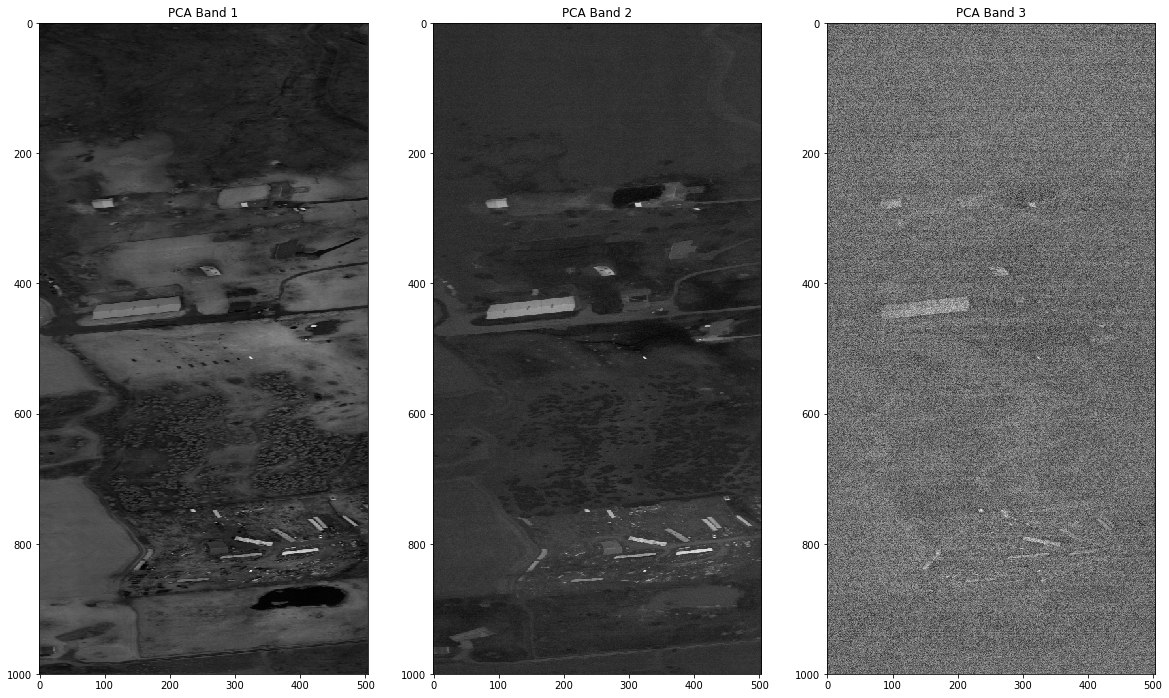

In [31]:
# Plot various bands from the image
# Squeeze() is needed to remove the single-dimensional band dimension
# before plotting (e.g. (nl, ns, 1) -> (nl, ns))
f, (plot1, plot2, plot3) = plt.subplots(1, 3)
plot1.imshow(reshape_pca_band(x_pca, 0, sz), cmap=plt.gray());
plot1.set_title('PCA Band 1');

plot2.imshow(reshape_pca_band(x_pca, 1, sz), cmap=plt.gray());
plot2.set_title('PCA Band 2');

plot3.imshow(reshape_pca_band(x_pca, 2, sz), cmap=plt.gray());
plot3.set_title('PCA Band 3');


## Split data into leading and trailing-order PCs
### Try it out on all of the data, as well as a masked version where only the background ("natural") pixels are used for mean/covariance calculations

In [10]:
# Number of leading order PCs (i.e. bands [0, K])
K = 10

leading_order_pcs = x_pca[:K, :]
trailing_order_pcs = x_pca[K:, :]

In [11]:
background_mask = np.ones_like(leading_order_pcs)
background_mask[:, background_ix] = 0
leading_order_pcs_masked = leading_order_pcs[:, background_ix]#np.ma.MaskedArray(leading_order_pcs, background_mask)

background_mask = np.ones_like(hsi_data_mat)
background_mask[:, background_ix] = 0
hsi_data_mat_masked = hsi_data_mat[:, background_ix]#np.ma.MaskedArray(hsi_data_mat, background_mask)
#np.ma.set_fill_value(hsi_data_mat_masked, np.nan)
#hsi_data_mat_masked[:, background_ix] = np.nan

## (Optional) Cull Pixels

In [12]:
outlier_ixs, valid_ixs = compute_multivariate_gaussian_statistics(trailing_order_pcs)
print('Number of outliers: {}'.format(outlier_ixs.shape))

Number of outliers: (1025,)


In [13]:
#leading_order_pcs_masked = np.delete(leading_order_pcs, outlier_ixs, axis=1)
leading_order_pcs_masked = leading_order_pcs[:, valid_ixs]
hsi_data_mat_masked = hsi_data_mat[:, valid_ixs]#np.ma.MaskedArray(hsi_data_mat, background_mask)


In [14]:
nl, ns, nb = sz
outlier_mask = np.zeros([nl*ns])
outlier_mask[outlier_ixs] = 1

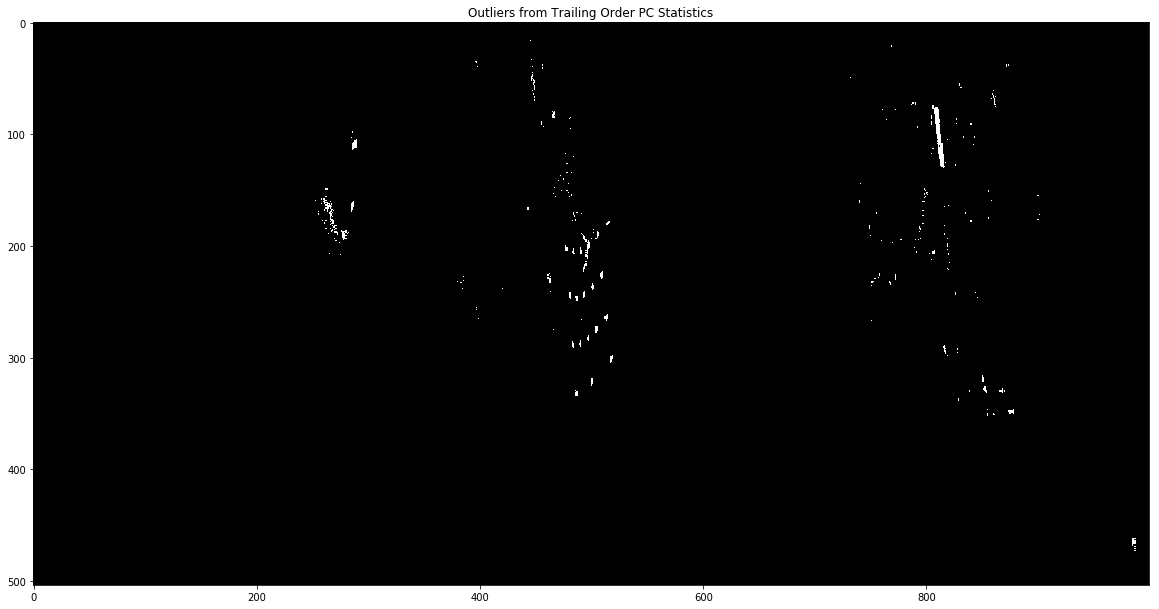

In [15]:
f, (plot1) = plt.subplots(1,1)
plot1.imshow(np.rot90(outlier_mask.reshape([nl, ns], order='F')), cmap=plt.gray());
plot1.set_title('Outliers from Trailing Order PC Statistics');

## Initial Class Assignment (leading-order PCs)

In [16]:
num_classes = 7

In [17]:
np.random.seed(12345)
cmi, cm, cc = initial_class_assignment(leading_order_pcs, num_classes)

In [18]:
#np.random.seed(12345)
cmi_masked, cm_masked, cc_masked = initial_class_assignment(leading_order_pcs_masked, num_classes)

In [19]:
#cmi, cm, cc = initial_class_assignment(leading_order_pcs, num_classes, method='select', init_indices=[blue_ix[0], brown_ix[0], camo_ix[0], white_ix[0], black_ix[0], background_ix[500], background_ix[50000]])

## Iterate through GSC Algorithm

In [33]:
%%timeit
#np.random.seed(12345)
final_class_ixs = iterate_clustering(leading_order_pcs, cmi, num_classes, 500, dead_class_threshold=10)

class counts [72437 71974 71694 71353 72296 72183 72063]
Finished iteration # 0
class counts [69001 81739 83766 77268 72447 58344 61435]
Finished iteration # 1
class counts [68866 88477 92767 81805 73273 39134 59678]
Finished iteration # 2
class counts [65572 91723 98369 83571 70746 34507 59512]
Finished iteration # 3
class counts [ 63046  92707 101351  83373  67606  31748  64169]
Finished iteration # 4
class counts [ 62715  93144 101845  82726  65146  27848  70576]
Finished iteration # 5
class counts [ 63770  94882 101302  81340  64055  23898  74753]
Finished iteration # 6
class counts [ 65689  97940 100324  80518  63314  20938  75277]
Finished iteration # 7
class counts [ 67502 101922  98847  80628  62501  18682  73918]
Finished iteration # 8
class counts [ 68460 107885  96066  81366  60985  17020  72218]
Finished iteration # 9
class counts [ 68546 115576  93423  81629  58686  15666  70474]
Finished iteration # 10
class counts [ 66597 124664  91717  81405  56136  14382  69099]
Finish

class counts [ 23908 138423  95387  90665  81894  10622  63101]
Finished iteration # 94
class counts [ 23857 138098  95299  91153  81849  10605  63139]
Finished iteration # 95
class counts [ 23815 138003  94996  91581  82006  10572  63027]
Finished iteration # 96
class counts [ 23632 138011  95212  91698  81780  10585  63082]
Finished iteration # 97
class counts [ 23618 137862  95043  92113  81597  10561  63206]
Finished iteration # 98
class counts [ 23678 137735  94684  92635  81430  10629  63209]
Finished iteration # 99
class counts [ 23662 137459  94738  92771  81686  10744  62940]
Finished iteration # 100
class counts [ 23691 137464  94624  93126  81294  10687  63114]
Finished iteration # 101
class counts [ 23622 137444  94747  93329  81128  10689  63041]
Finished iteration # 102
class counts [ 23656 137415  94705  93549  81195  10625  62855]
Finished iteration # 103
class counts [ 23698 137406  94946  93456  80759  10640  63095]
Finished iteration # 104
class counts [ 23729 137396

class counts [ 23134 132669  92408 102729  79007  10581  63472]
Finished iteration # 187
class counts [ 23161 132632  92425 102942  78857  10551  63432]
Finished iteration # 188
class counts [ 23164 132585  92658 102772  78812  10505  63504]
Finished iteration # 189
class counts [ 23234 132406  92601 102607  79064  10550  63538]
Finished iteration # 190
class counts [ 23229 132488  92552 102748  78904  10517  63562]
Finished iteration # 191
class counts [ 23220 132680  92660 102769  78453  10578  63640]
Finished iteration # 192
class counts [ 23312 132654  92906 102483  78460  10561  63624]
Finished iteration # 193
class counts [ 23269 132757  92749 102662  78434  10658  63471]
Finished iteration # 194
class counts [ 23188 132571  92698 102896  78586  10665  63396]
Finished iteration # 195
class counts [ 23189 132715  92432 102996  78588  10682  63398]
Finished iteration # 196
class counts [ 23224 132634  92405 102764  78647  10664  63662]
Finished iteration # 197
class counts [ 23280 

class counts [ 23125 132317  91422 103780  79154  10644  63558]
Finished iteration # 280
class counts [ 23093 132545  91577 103533  78955  10669  63628]
Finished iteration # 281
class counts [ 23163 132504  91680 103431  78972  10670  63580]
Finished iteration # 282
class counts [ 23165 132504  91730 103419  78802  10663  63717]
Finished iteration # 283
class counts [ 23177 132430  91615 103327  79147  10677  63627]
Finished iteration # 284
class counts [ 23135 132310  91276 103408  79595  10720  63556]
Finished iteration # 285
class counts [ 23146 132397  90998 103793  79421  10715  63530]
Finished iteration # 286
class counts [ 23175 132403  90763 103679  79690  10740  63550]
Finished iteration # 287
class counts [ 23110 132491  90832 103550  79484  10712  63821]
Finished iteration # 288
class counts [ 23110 132572  90795 103390  79419  10711  64003]
Finished iteration # 289
class counts [ 23081 132633  90861 103359  79351  10652  64063]
Finished iteration # 290
class counts [ 23126 

class counts [ 23013 132154  91013 104552  78798  10653  63817]
Finished iteration # 373
class counts [ 22984 132307  91073 104271  78987  10619  63759]
Finished iteration # 374
class counts [ 23146 132175  90815 104660  79006  10604  63594]
Finished iteration # 375
class counts [ 23187 132074  90779 104689  79056  10674  63541]
Finished iteration # 376
class counts [ 23074 132192  90647 104853  79050  10717  63467]
Finished iteration # 377
class counts [ 23154 132162  90697 104633  79141  10638  63575]
Finished iteration # 378
class counts [ 23063 132178  91104 104192  79075  10647  63741]
Finished iteration # 379
class counts [ 22944 132327  90904 104370  79122  10625  63708]
Finished iteration # 380
class counts [ 23050 132352  91024 104032  79303  10636  63603]
Finished iteration # 381
class counts [ 23091 132332  91027 103832  79459  10578  63681]
Finished iteration # 382
class counts [ 23083 131989  91243 103649  79742  10636  63658]
Finished iteration # 383
class counts [ 23068 

class counts [ 23121 132341  91408 103671  79094  10654  63711]
Finished iteration # 466
class counts [ 23122 132308  91382 103796  79204  10650  63538]
Finished iteration # 467
class counts [ 23120 132197  91487 103602  79545  10579  63470]
Finished iteration # 468
class counts [ 23105 132508  91400 103656  79214  10608  63509]
Finished iteration # 469
class counts [ 23131 132237  91108 103882  79449  10597  63596]
Finished iteration # 470
class counts [ 23148 132443  91194 103853  79149  10625  63588]
Finished iteration # 471
class counts [ 23201 132413  91172 104010  78993  10662  63549]
Finished iteration # 472
class counts [ 23124 132670  91133 103865  79021  10655  63532]
Finished iteration # 473
class counts [ 23191 132709  91404 103731  78756  10657  63552]
Finished iteration # 474
class counts [ 23152 132628  91465 103898  78699  10570  63588]
Finished iteration # 475
class counts [ 23219 132622  91566 103635  78845  10601  63512]
Finished iteration # 476
class counts [ 23141 

class counts [ 25863 146271  68707  76436 107282  10624  68817]
Finished iteration # 60
class counts [ 25094 146254  67975  77091 107908  10610  69068]
Finished iteration # 61
class counts [ 24522 146152  67208  77747 108726  10557  69088]
Finished iteration # 62
class counts [ 23958 146394  66587  78193 109172  10538  69158]
Finished iteration # 63
class counts [ 23543 146610  65593  78804 109754  10655  69041]
Finished iteration # 64
class counts [ 23270 146589  64958  79162 110375  10744  68902]
Finished iteration # 65
class counts [ 23017 146601  64219  79573 110996  10726  68868]
Finished iteration # 66
class counts [ 22868 146716  63244  80316 111397  10745  68714]
Finished iteration # 67
class counts [ 22645 146737  62497  80825 111829  10725  68742]
Finished iteration # 68
class counts [ 22617 146987  61536  81339 112151  10662  68708]
Finished iteration # 69
class counts [ 22412 147038  60735  81660 112842  10665  68648]
Finished iteration # 70
class counts [ 22431 147147  598

class counts [ 22119 150499  29785  92701 131933  10545  66418]
Finished iteration # 153
class counts [ 22096 150899  29718  92788 131698  10603  66198]
Finished iteration # 154
class counts [ 22085 150812  29800  92694 131955  10504  66150]
Finished iteration # 155
class counts [ 22103 150724  29672  92567 132215  10519  66200]
Finished iteration # 156
class counts [ 22047 150859  29729  92538 132012  10578  66237]
Finished iteration # 157
class counts [ 22098 150904  29662  92670 131818  10581  66267]
Finished iteration # 158
class counts [ 22036 151116  29651  92707 131613  10574  66303]
Finished iteration # 159
class counts [ 22050 151043  29615  92788 131551  10585  66368]
Finished iteration # 160
class counts [ 22020 151032  29559  92950 131501  10554  66384]
Finished iteration # 161
class counts [ 22051 150891  29669  92997 131535  10526  66331]
Finished iteration # 162
class counts [ 22102 150901  29812  92675 131462  10604  66444]
Finished iteration # 163
class counts [ 22163 

class counts [ 22105 151078  29734  91460 132255  10552  66816]
Finished iteration # 246
class counts [ 22001 151328  29769  91457 132203  10569  66673]
Finished iteration # 247
class counts [ 22038 151146  29653  91473 132349  10615  66726]
Finished iteration # 248
class counts [ 21982 151192  29700  91379 132436  10573  66738]
Finished iteration # 249
class counts [ 21953 151437  29729  91178 132586  10528  66589]
Finished iteration # 250
class counts [ 22041 151342  29665  91376 132378  10505  66693]
Finished iteration # 251
class counts [ 22138 151211  29742  91535 132067  10517  66790]
Finished iteration # 252
class counts [ 22213 151265  29795  91631 132029  10523  66544]
Finished iteration # 253
class counts [ 22143 151191  29677  91615 132268  10543  66563]
Finished iteration # 254
class counts [ 22189 151446  29707  91528 132139  10548  66443]
Finished iteration # 255
class counts [ 22104 151301  29803  91314 132199  10547  66732]
Finished iteration # 256
class counts [ 22059 

class counts [ 22120 151077  29837  90651 132958  10572  66785]
Finished iteration # 339
class counts [ 22257 151081  29851  90694 132887  10572  66658]
Finished iteration # 340
class counts [ 22130 151158  29830  90760 132719  10501  66902]
Finished iteration # 341
class counts [ 22059 150886  29832  90663 133158  10535  66867]
Finished iteration # 342
class counts [ 22149 150934  29706  90639 133299  10479  66794]
Finished iteration # 343
class counts [ 22149 150833  29886  90654 133097  10395  66986]
Finished iteration # 344
class counts [ 22147 151001  29838  90436 133054  10475  67049]
Finished iteration # 345
class counts [ 22236 151227  29781  90547 132848  10515  66846]
Finished iteration # 346
class counts [ 22216 150928  29639  90408 133592  10544  66673]
Finished iteration # 347
class counts [ 22119 150857  29614  90373 133829  10497  66711]
Finished iteration # 348
class counts [ 22184 150991  29591  90733 133087  10528  66886]
Finished iteration # 349
class counts [ 22155 

class counts [ 22183 150884  29534  91554 132288  10540  67017]
Finished iteration # 432
class counts [ 22165 151008  29440  91574 132314  10466  67033]
Finished iteration # 433
class counts [ 22200 150975  29409  91560 132420  10503  66933]
Finished iteration # 434
class counts [ 22051 150990  29589  91655 132185  10556  66974]
Finished iteration # 435
class counts [ 22076 150910  29655  91330 132551  10610  66868]
Finished iteration # 436
class counts [ 22092 151043  29575  91253 132265  10602  67170]
Finished iteration # 437
class counts [ 22047 151398  29566  91158 132149  10598  67084]
Finished iteration # 438
class counts [ 22117 151291  29569  91251 131969  10564  67239]
Finished iteration # 439
class counts [ 22183 151355  29701  91565 131437  10557  67202]
Finished iteration # 440
class counts [ 22158 151349  29579  91563 131504  10542  67305]
Finished iteration # 441
class counts [ 22150 151128  29428  91580 132053  10476  67185]
Finished iteration # 442
class counts [ 22137 

class counts [ 56771 156079  88916  81105  49763  10594  60772]
Finished iteration # 25
class counts [ 56158 156217  89169  80615  50890  10478  60473]
Finished iteration # 26
class counts [ 55276 156170  89530  79899  52404  10467  60254]
Finished iteration # 27
class counts [ 54487 156245  89640  79361  53924  10456  59887]
Finished iteration # 28
class counts [ 53795 155941  90147  78836  55300  10380  59601]
Finished iteration # 29
class counts [ 53081 155829  90609  78318  56406  10337  59420]
Finished iteration # 30
class counts [ 52251 155530  90760  77913  57877  10379  59290]
Finished iteration # 31
class counts [ 51437 155421  91573  77101  59148  10282  59038]
Finished iteration # 32
class counts [ 50382 155171  92105  76590  60703  10298  58751]
Finished iteration # 33
class counts [ 49365 154593  92568  76352  62195  10270  58657]
Finished iteration # 34
class counts [ 48480 153936  92770  76253  63822  10311  58428]
Finished iteration # 35
class counts [ 47558 153670  933

class counts [ 23438 135038  93986  97869  79684  10632  63353]
Finished iteration # 118
class counts [ 23457 135412  94088  97888  79020  10734  63401]
Finished iteration # 119
class counts [ 23407 135338  93996  97957  79081  10665  63556]
Finished iteration # 120
class counts [ 23467 135494  93973  98044  78851  10690  63481]
Finished iteration # 121
class counts [ 23490 135345  93774  98229  78983  10674  63505]
Finished iteration # 122
class counts [ 23435 135151  94150  98257  78629  10649  63729]
Finished iteration # 123
class counts [ 23471 134958  94168  98362  78916  10641  63484]
Finished iteration # 124
class counts [ 23377 134721  94173  98536  79145  10624  63424]
Finished iteration # 125
class counts [ 23275 134718  93531  98867  79445  10620  63544]
Finished iteration # 126
class counts [ 23319 134879  93584  98750  79318  10590  63560]
Finished iteration # 127
class counts [ 23341 134669  93711  98748  79311  10597  63623]
Finished iteration # 128
class counts [ 23480 

class counts [ 23180 133045  92392 102619  78713  10547  63504]
Finished iteration # 211
class counts [ 23245 132912  92176 102676  79022  10646  63323]
Finished iteration # 212
class counts [ 23244 132601  92118 102628  79359  10676  63374]
Finished iteration # 213
class counts [ 23242 132823  92027 102592  79388  10715  63213]
Finished iteration # 214
class counts [ 23336 133086  91835 102559  79210  10705  63269]
Finished iteration # 215
class counts [ 23290 133162  91810 102447  79127  10712  63452]
Finished iteration # 216
class counts [ 23275 133081  91620 102601  79179  10760  63484]
Finished iteration # 217
class counts [ 23287 133226  91792 102490  78949  10776  63480]
Finished iteration # 218
class counts [ 23202 133306  92073 102378  78805  10715  63521]
Finished iteration # 219
class counts [ 23148 133105  91749 102676  79056  10627  63639]
Finished iteration # 220
class counts [ 23208 132947  91634 102708  79116  10642  63745]
Finished iteration # 221
class counts [ 23247 

class counts [ 23086 132557  91458 103632  79859  10643  62765]
Finished iteration # 304
class counts [ 23057 132618  91402 103534  79995  10712  62682]
Finished iteration # 305
class counts [ 23068 132523  91437 103564  80115  10727  62566]
Finished iteration # 306
class counts [ 23142 132560  91787 103143  79937  10647  62784]
Finished iteration # 307
class counts [ 23199 132709  91588 103262  79733  10589  62920]
Finished iteration # 308
class counts [ 23229 132363  90954 103660  80097  10691  63006]
Finished iteration # 309
class counts [ 23153 132574  90922 103757  79837  10652  63105]
Finished iteration # 310
class counts [ 23170 132552  90946 103766  79849  10597  63120]
Finished iteration # 311
class counts [ 23161 132505  91187 103535  79898  10607  63107]
Finished iteration # 312
class counts [ 23138 132398  91064 103566  79963  10729  63142]
Finished iteration # 313
class counts [ 22984 132221  90937 103820  80222  10681  63135]
Finished iteration # 314
class counts [ 23021 

class counts [ 23136 133039  91304 103662  78950  10631  63278]
Finished iteration # 397
class counts [ 23117 133018  91196 103818  78687  10681  63483]
Finished iteration # 398
class counts [ 23123 133144  91257 103785  78343  10619  63729]
Finished iteration # 399
class counts [ 23230 133070  91035 104018  78392  10651  63604]
Finished iteration # 400
class counts [ 23109 132998  91052 104238  78343  10639  63621]
Finished iteration # 401
class counts [ 23069 132788  91055 104037  78640  10611  63800]
Finished iteration # 402
class counts [ 22896 132780  91146 104172  78795  10593  63618]
Finished iteration # 403
class counts [ 22984 132631  91145 103817  79274  10634  63515]
Finished iteration # 404
class counts [ 23026 132274  91500 103620  79239  10665  63676]
Finished iteration # 405
class counts [ 23127 132256  91679 103451  79440  10668  63379]
Finished iteration # 406
class counts [ 23133 132352  91640 103325  79561  10597  63392]
Finished iteration # 407
class counts [ 23202 

class counts [ 23042 132747  92171 103385  78699  10692  63264]
Finished iteration # 490
class counts [ 23196 132769  92290 103246  78572  10711  63216]
Finished iteration # 491
class counts [ 23125 132459  92757 102899  78862  10607  63291]
Finished iteration # 492
class counts [ 23174 132072  92820 102881  79026  10647  63380]
Finished iteration # 493
class counts [ 23204 132366  92955 102611  78973  10602  63289]
Finished iteration # 494
class counts [ 23107 132532  92830 102734  78859  10629  63309]
Finished iteration # 495
class counts [ 23081 132545  92786 102899  78559  10641  63489]
Finished iteration # 496
class counts [ 23123 132728  92766 102840  78367  10580  63596]
Finished iteration # 497
class counts [ 23108 132694  92778 102869  78531  10639  63381]
Finished iteration # 498
class counts [ 23183 132693  92657 102919  78635  10633  63280]
Finished iteration # 499
class counts [72393 71954 71664 71592 72363 72754 71280]
Finished iteration # 0
class counts [69585 81129 8338

class counts [ 22217 149033  54328  92385 109598  10633  65806]
Finished iteration # 84
class counts [ 22146 148900  53185  92972 110359  10627  65811]
Finished iteration # 85
class counts [ 22137 149137  52037  93392 111046  10581  65670]
Finished iteration # 86
class counts [ 22179 149105  50778  93757 111946  10624  65611]
Finished iteration # 87
class counts [ 22265 149172  49546  94128 112640  10551  65698]
Finished iteration # 88
class counts [ 22365 149239  48539  94406 113141  10530  65780]
Finished iteration # 89
class counts [ 22318 149405  47591  94433 113865  10653  65735]
Finished iteration # 90
class counts [ 22255 149321  46512  94796 114715  10660  65741]
Finished iteration # 91
class counts [ 22208 149415  45415  95114 115349  10718  65781]
Finished iteration # 92
class counts [ 22211 149489  44200  95530 116039  10694  65837]
Finished iteration # 93
class counts [ 22316 149440  42879  96036 116710  10674  65945]
Finished iteration # 94
class counts [ 22370 149527  418

class counts [ 22078 151340  29747  92170 131494  10565  66606]
Finished iteration # 177
class counts [ 22094 151328  29823  92048 131706  10580  66421]
Finished iteration # 178
class counts [ 22097 151143  29803  91997 131836  10573  66551]
Finished iteration # 179
class counts [ 22013 151254  29891  92130 131460  10574  66678]
Finished iteration # 180
class counts [ 22038 151138  29846  91924 131977  10589  66488]
Finished iteration # 181
class counts [ 22093 151105  29844  91664 132195  10605  66494]
Finished iteration # 182
class counts [ 22116 151182  29704  91632 132261  10510  66595]
Finished iteration # 183
class counts [ 22026 151286  29679  91722 132124  10545  66618]
Finished iteration # 184
class counts [ 22011 151370  29725  91748 131957  10551  66638]
Finished iteration # 185
class counts [ 22037 151405  29835  91736 131810  10527  66650]
Finished iteration # 186
class counts [ 21974 151086  29853  91868 131967  10466  66786]
Finished iteration # 187
class counts [ 22001 

class counts [ 22099 151279  29839  90665 132815  10541  66762]
Finished iteration # 270
class counts [ 22147 151391  29881  90666 132882  10519  66514]
Finished iteration # 271
class counts [ 22135 151353  29934  90593 132977  10469  66539]
Finished iteration # 272
class counts [ 22130 151351  29882  90616 133046  10486  66489]
Finished iteration # 273
class counts [ 22147 151341  29838  90687 133002  10529  66456]
Finished iteration # 274
class counts [ 22089 151231  29712  90951 132819  10547  66651]
Finished iteration # 275
class counts [ 22040 151092  29825  91152 132878  10541  66472]
Finished iteration # 276
class counts [ 22170 151029  29914  91111 132616  10535  66625]
Finished iteration # 277
class counts [ 22220 151034  29718  91247 132449  10489  66843]
Finished iteration # 278
class counts [ 22148 151237  29817  91380 132150  10509  66759]
Finished iteration # 279
class counts [ 22056 151188  29788  90994 132817  10545  66612]
Finished iteration # 280
class counts [ 22165 

class counts [ 22172 151582  29807  91842 131899  10590  66108]
Finished iteration # 363
class counts [ 22089 151455  29772  91812 132079  10653  66140]
Finished iteration # 364
class counts [ 21999 151631  29697  91663 132263  10597  66150]
Finished iteration # 365
class counts [ 22156 151676  29637  91474 132390  10608  66059]
Finished iteration # 366
class counts [ 22205 151405  29653  91619 132523  10580  66015]
Finished iteration # 367
class counts [ 22251 151046  29711  91845 132485  10542  66120]
Finished iteration # 368
class counts [ 22101 151089  29658  91716 132669  10452  66315]
Finished iteration # 369
class counts [ 22202 151028  29820  91829 132482  10476  66163]
Finished iteration # 370
class counts [ 22112 151099  29855  91687 132529  10422  66296]
Finished iteration # 371
class counts [ 22151 151074  29746  91483 132594  10407  66545]
Finished iteration # 372
class counts [ 22189 151112  29898  91388 132491  10377  66545]
Finished iteration # 373
class counts [ 22265 

class counts [ 22164 151086  29961  90589 132783  10507  66910]
Finished iteration # 456
class counts [ 22108 151089  29753  90855 132857  10509  66829]
Finished iteration # 457
class counts [ 22166 151260  29915  90805 132600  10464  66790]
Finished iteration # 458
class counts [ 22168 151093  29880  90585 133057  10472  66745]
Finished iteration # 459
class counts [ 22139 151167  29848  90622 132857  10395  66972]
Finished iteration # 460
class counts [ 22053 151121  29790  90944 132665  10424  67003]
Finished iteration # 461
class counts [ 22134 151256  29844  91009 132391  10420  66946]
Finished iteration # 462
class counts [ 22142 151167  29771  91209 132313  10444  66954]
Finished iteration # 463
class counts [ 22126 151264  29806  91381 132096  10445  66882]
Finished iteration # 464
class counts [ 22117 151357  29814  91414 131987  10500  66811]
Finished iteration # 465
class counts [ 22312 151136  29743  91396 132197  10466  66750]
Finished iteration # 466
class counts [ 22204 

class counts [ 67613 152637  63867  73321  70710  10433  65419]
Finished iteration # 50
class counts [ 67276 152803  63262  73644  71380  10506  65129]
Finished iteration # 51
class counts [ 66760 153010  62670  74201  71927  10512  64920]
Finished iteration # 52
class counts [ 66075 152613  61902  74731  73250  10483  64946]
Finished iteration # 53
class counts [ 65316 152837  61019  74915  74526  10478  64909]
Finished iteration # 54
class counts [ 64658 153034  60063  75255  75829  10453  64708]
Finished iteration # 55
class counts [ 63997 152915  59136  75451  77459  10448  64594]
Finished iteration # 56
class counts [ 63554 152995  58469  75584  78457  10414  64527]
Finished iteration # 57
class counts [ 62762 152970  57634  76094  79870  10448  64222]
Finished iteration # 58
class counts [ 62008 152879  56609  76618  81125  10500  64261]
Finished iteration # 59
class counts [ 61013 152513  55836  77029  82746  10516  64347]
Finished iteration # 60
class counts [ 60092 152494  548

class counts [ 21925 151082  29470  91801 132801  10564  66357]
Finished iteration # 143
class counts [ 21928 151080  29573  91454 133160  10526  66279]
Finished iteration # 144
class counts [ 21936 150980  29455  91552 133298  10530  66249]
Finished iteration # 145
class counts [ 21949 151009  29439  91686 132952  10585  66380]
Finished iteration # 146
class counts [ 22049 151185  29424  91874 132490  10519  66459]
Finished iteration # 147
class counts [ 21999 151174  29561  91529 132661  10512  66564]
Finished iteration # 148
class counts [ 22101 151008  29658  91368 132821  10519  66525]
Finished iteration # 149
class counts [ 22176 151018  29588  91386 132810  10592  66430]
Finished iteration # 150
class counts [ 22190 151043  29595  91361 132940  10584  66287]
Finished iteration # 151
class counts [ 22190 150856  29632  91199 133232  10635  66256]
Finished iteration # 152
class counts [ 22230 150818  29617  91274 133246  10603  66212]
Finished iteration # 153
class counts [ 22141 

class counts [ 22121 150842  29558  91407 133055  10553  66464]
Finished iteration # 236
class counts [ 22153 150902  29565  91279 132973  10473  66655]
Finished iteration # 237
class counts [ 22164 151230  29530  91151 132922  10518  66485]
Finished iteration # 238
class counts [ 22151 151163  29628  91023 133005  10391  66639]
Finished iteration # 239
class counts [ 22058 151034  29672  90932 133173  10378  66753]
Finished iteration # 240
class counts [ 21991 151093  29598  90945 133061  10359  66953]
Finished iteration # 241
class counts [ 22186 150952  29490  91017 133141  10415  66799]
Finished iteration # 242
class counts [ 22195 151156  29580  91005 132897  10468  66699]
Finished iteration # 243
class counts [ 22259 150904  29721  90933 133025  10498  66660]
Finished iteration # 244
class counts [ 22213 151010  29718  91064 132785  10437  66773]
Finished iteration # 245
class counts [ 22114 151045  29671  91034 132909  10500  66727]
Finished iteration # 246
class counts [ 22032 

class counts [ 22189 150948  29745  91629 132183  10451  66855]
Finished iteration # 329
class counts [ 22210 151065  29612  91459 132413  10450  66791]
Finished iteration # 330
class counts [ 22074 151075  29651  91400 132452  10468  66880]
Finished iteration # 331
class counts [ 22056 151186  29743  91391 132148  10416  67060]
Finished iteration # 332
class counts [ 22053 151174  29855  91170 132303  10433  67012]
Finished iteration # 333
class counts [ 22093 151384  29799  91503 132060  10414  66747]
Finished iteration # 334
class counts [ 22071 151248  29706  91635 131993  10515  66832]
Finished iteration # 335
class counts [ 22146 151205  29591  91860 132057  10478  66663]
Finished iteration # 336
class counts [ 22171 151447  29629  91959 131446  10474  66874]
Finished iteration # 337
class counts [ 22095 151284  29731  92153 131353  10466  66918]
Finished iteration # 338
class counts [ 22192 151166  29591  92235 131668  10446  66702]
Finished iteration # 339
class counts [ 22119 

class counts [ 22197 150667  29490  90709 133442  10537  66958]
Finished iteration # 422
class counts [ 22188 150683  29666  90513 133444  10552  66954]
Finished iteration # 423
class counts [ 22136 150876  29696  90386 133511  10545  66850]
Finished iteration # 424
class counts [ 22172 151197  29658  90558 132922  10599  66894]
Finished iteration # 425
class counts [ 22162 151066  29606  90665 132972  10620  66909]
Finished iteration # 426
class counts [ 22174 150959  29577  90646 133198  10572  66874]
Finished iteration # 427
class counts [ 22137 151201  29742  90623 133076  10571  66650]
Finished iteration # 428
class counts [ 22114 151090  29706  90889 132949  10564  66688]
Finished iteration # 429
class counts [ 22062 150886  29842  90695 133243  10524  66748]
Finished iteration # 430
class counts [ 22099 150996  29831  90754 132743  10462  67115]
Finished iteration # 431
class counts [ 22054 151276  29673  90825 132862  10466  66844]
Finished iteration # 432
class counts [ 22114 

class counts [ 65225 132611  92908  78859  56845  11772  65780]
Finished iteration # 15
class counts [ 63520 138274  93966  79265  52953  11343  64679]
Finished iteration # 16
class counts [ 62376 142226  94577  79535  50274  10979  64033]
Finished iteration # 17
class counts [ 61820 144741  94673  79499  49290  10835  63142]
Finished iteration # 18
class counts [ 61264 146182  94174  79205  49628  10684  62863]
Finished iteration # 19
class counts [ 61035 147057  94207  78479  50190  10544  62488]
Finished iteration # 20
class counts [ 60692 147564  93899  78189  50726  10504  62426]
Finished iteration # 21
class counts [ 60400 148092  93637  77643  51555  10384  62289]
Finished iteration # 22
class counts [ 60046 148372  93521  77070  52374  10433  62184]
Finished iteration # 23
class counts [ 59154 148733  93545  76651  53339  10400  62178]
Finished iteration # 24
class counts [ 58580 149117  93682  76054  54292  10408  61867]
Finished iteration # 25
class counts [ 57901 149365  938

class counts [ 23544 133456  93683 100892  78563  10593  63269]
Finished iteration # 109
class counts [ 23438 133343  93418 101161  78780  10643  63217]
Finished iteration # 110
class counts [ 23405 133433  93795 101197  78245  10655  63270]
Finished iteration # 111
class counts [ 23428 133351  93737 101178  78348  10667  63291]
Finished iteration # 112
class counts [ 23363 133442  93637 101277  77973  10607  63701]
Finished iteration # 113
class counts [ 23315 133096  93543 101347  78528  10586  63585]
Finished iteration # 114
class counts [ 23380 133006  93494 101675  78410  10583  63452]
Finished iteration # 115
class counts [ 23404 132908  93718 101480  78417  10611  63462]
Finished iteration # 116
class counts [ 23378 132997  93626 101493  78454  10666  63386]
Finished iteration # 117
class counts [ 23364 133067  93622 101684  78061  10670  63532]
Finished iteration # 118
class counts [ 23319 133201  93367 101766  78066  10666  63615]
Finished iteration # 119
class counts [ 23271 

class counts [ 23199 132560  91579 103790  78510  10666  63696]
Finished iteration # 202
class counts [ 23208 132739  91728 103788  78207  10550  63780]
Finished iteration # 203
class counts [ 23179 132639  91810 103664  78334  10617  63757]
Finished iteration # 204
class counts [ 23106 132661  92087 103747  78259  10645  63495]
Finished iteration # 205
class counts [ 23226 132962  92135 103686  77991  10664  63336]
Finished iteration # 206
class counts [ 23234 133086  92097 103603  77990  10653  63337]
Finished iteration # 207
class counts [ 23294 132947  92226 103405  78012  10643  63473]
Finished iteration # 208
class counts [ 23250 132839  92010 103515  78355  10644  63387]
Finished iteration # 209
class counts [ 23263 132885  91965 103176  78594  10584  63533]
Finished iteration # 210
class counts [ 23256 132708  92118 103120  78589  10574  63635]
Finished iteration # 211
class counts [ 23290 132775  92187 103167  78374  10546  63661]
Finished iteration # 212
class counts [ 23237 

class counts [ 23198 132222  91659 104062  78945  10536  63378]
Finished iteration # 295
class counts [ 23134 132422  91446 104133  79036  10633  63196]
Finished iteration # 296
class counts [ 23053 132385  91638 103862  79076  10644  63342]
Finished iteration # 297
class counts [ 23057 132413  91625 103696  79139  10679  63391]
Finished iteration # 298
class counts [ 22887 132460  91435 103892  79059  10670  63597]
Finished iteration # 299
class counts [ 23038 132315  91412 103832  79414  10679  63310]
Finished iteration # 300
class counts [ 22953 132387  91354 103830  79383  10535  63558]
Finished iteration # 301
class counts [ 23027 132455  91310 103926  79234  10574  63474]
Finished iteration # 302
class counts [ 23122 132168  91432 104004  79255  10617  63402]
Finished iteration # 303
class counts [ 23039 132233  91438 104257  79308  10554  63171]
Finished iteration # 304
class counts [ 22949 132154  91140 104464  79544  10572  63177]
Finished iteration # 305
class counts [ 22880 

class counts [ 23296 131808  92124 103014  79573  10688  63497]
Finished iteration # 388
class counts [ 23246 131880  92096 102981  79542  10642  63613]
Finished iteration # 389
class counts [ 23240 131643  92061 103140  79551  10645  63720]
Finished iteration # 390
class counts [ 23281 131664  92017 103397  79425  10584  63632]
Finished iteration # 391
class counts [ 23235 131830  92109 103202  79195  10648  63781]
Finished iteration # 392
class counts [ 23112 131876  92249 103250  78952  10658  63903]
Finished iteration # 393
class counts [ 23158 131984  91906 103447  78965  10684  63856]
Finished iteration # 394
class counts [ 23201 132070  92084 103388  78954  10616  63687]
Finished iteration # 395
class counts [ 23195 132105  92208 103196  78982  10568  63746]
Finished iteration # 396
class counts [ 23146 132078  92075 103382  79102  10623  63594]
Finished iteration # 397
class counts [ 23155 132156  92037 103239  79084  10620  63709]
Finished iteration # 398
class counts [ 23174 

class counts [ 23185 132394  91694 104074  78671  10585  63397]
Finished iteration # 481
class counts [ 23162 132478  91791 103806  78509  10580  63674]
Finished iteration # 482
class counts [ 23239 132419  91881 103658  78404  10609  63790]
Finished iteration # 483
class counts [ 23273 132454  91994 103334  78586  10580  63779]
Finished iteration # 484
class counts [ 23253 132365  92195 103230  78621  10573  63763]
Finished iteration # 485
class counts [ 23299 132401  92384 102921  78823  10494  63678]
Finished iteration # 486
class counts [ 23292 132328  92360 102688  78741  10523  64068]
Finished iteration # 487
class counts [ 23289 132161  92555 102838  78693  10513  63951]
Finished iteration # 488
class counts [ 23236 132223  92686 102834  78730  10544  63747]
Finished iteration # 489
class counts [ 23297 132261  92469 102772  78900  10613  63688]
Finished iteration # 490
class counts [ 23234 132356  92178 103304  78511  10589  63828]
Finished iteration # 491
class counts [ 23255 

class counts [ 29028 149641  68071  82728  99230  10549  64753]
Finished iteration # 75
class counts [ 27619 149431  67045  83555 100565  10488  65297]
Finished iteration # 76
class counts [ 26418 149415  66251  84299 101533  10526  65558]
Finished iteration # 77
class counts [ 25395 148934  65474  85006 102712  10505  65974]
Finished iteration # 78
class counts [ 24701 148838  64520  85553 103850  10545  65993]
Finished iteration # 79
class counts [ 24055 148724  63283  86039 105198  10582  66119]
Finished iteration # 80
class counts [ 23616 148541  62678  86527 105670  10619  66349]
Finished iteration # 81
class counts [ 23253 148643  61790  87146 106237  10560  66371]
Finished iteration # 82
class counts [ 22973 148748  60819  87677 106918  10548  66317]
Finished iteration # 83
class counts [ 22773 148572  59881  88257 107634  10588  66295]
Finished iteration # 84
class counts [ 22682 148505  58667  88772 108464  10653  66257]
Finished iteration # 85
class counts [ 22539 148651  574

class counts [ 22204 151193  29660  92545 131329  10435  66634]
Finished iteration # 168
class counts [ 22160 151226  29640  92671 130895  10461  66947]
Finished iteration # 169
class counts [ 22146 150968  29741  92706 131228  10488  66723]
Finished iteration # 170
class counts [ 22104 151129  29702  92488 131463  10483  66631]
Finished iteration # 171
class counts [ 22167 150732  29739  92165 132068  10446  66683]
Finished iteration # 172
class counts [ 22199 150880  29682  91968 132219  10454  66598]
Finished iteration # 173
class counts [ 22173 150946  29622  91928 132142  10466  66723]
Finished iteration # 174
class counts [ 22112 150794  29825  91730 132366  10513  66660]
Finished iteration # 175
class counts [ 22052 150560  29764  91670 132745  10530  66679]
Finished iteration # 176
class counts [ 22061 150575  29811  91595 132624  10578  66756]
Finished iteration # 177
class counts [ 22072 150673  29595  91902 132351  10645  66762]
Finished iteration # 178
class counts [ 22092 

class counts [ 21997 151365  29789  92338 131682  10567  66262]
Finished iteration # 261
class counts [ 22026 151466  29788  92093 131917  10579  66131]
Finished iteration # 262
class counts [ 22072 151490  29786  92259 131796  10611  65986]
Finished iteration # 263
class counts [ 22078 151577  29759  92116 131939  10604  65927]
Finished iteration # 264
class counts [ 22033 151782  29723  92174 131822  10582  65884]
Finished iteration # 265
class counts [ 22090 151541  29624  92177 132141  10655  65772]
Finished iteration # 266
class counts [ 22124 151741  29607  91985 132074  10610  65859]
Finished iteration # 267
class counts [ 22030 151548  29629  91942 132307  10539  66005]
Finished iteration # 268
class counts [ 22011 151534  29708  91970 132246  10611  65920]
Finished iteration # 269
class counts [ 21984 151651  29702  91849 132369  10523  65922]
Finished iteration # 270
class counts [ 21950 151404  29670  92089 132226  10514  66147]
Finished iteration # 271
class counts [ 22048 

class counts [ 22111 150625  29675  91609 132168  10529  67283]
Finished iteration # 354
class counts [ 22127 150687  29684  91819 132043  10457  67183]
Finished iteration # 355
class counts [ 22118 150669  29615  91890 131933  10450  67325]
Finished iteration # 356
class counts [ 22154 150652  29574  91793 132220  10540  67067]
Finished iteration # 357
class counts [ 22075 150966  29452  91805 132509  10501  66692]
Finished iteration # 358
class counts [ 22074 151019  29571  91775 132364  10527  66670]
Finished iteration # 359
class counts [ 22047 151003  29708  91748 132451  10557  66486]
Finished iteration # 360
class counts [ 22129 150912  29615  91762 132405  10497  66680]
Finished iteration # 361
class counts [ 22186 150891  29679  92040 131939  10512  66753]
Finished iteration # 362
class counts [ 22130 150744  29729  92020 132289  10531  66557]
Finished iteration # 363
class counts [ 22116 151039  29648  92163 131786  10555  66693]
Finished iteration # 364
class counts [ 22039 

class counts [ 22170 150843  29695  91086 132871  10574  66761]
Finished iteration # 447
class counts [ 22207 151118  29597  91041 132671  10601  66765]
Finished iteration # 448
class counts [ 22190 150850  29601  90830 133092  10498  66939]
Finished iteration # 449
class counts [ 22146 151116  29664  90589 133156  10538  66791]
Finished iteration # 450
class counts [ 22201 151063  29698  91079 132646  10520  66793]
Finished iteration # 451
class counts [ 22160 150962  29694  91172 132739  10607  66666]
Finished iteration # 452
class counts [ 22192 150824  29643  91193 132629  10658  66861]
Finished iteration # 453
class counts [ 22210 150937  29670  91061 132540  10637  66945]
Finished iteration # 454
class counts [ 22238 151150  29827  90977 132296  10623  66889]
Finished iteration # 455
class counts [ 22219 151170  29842  90859 132809  10604  66497]
Finished iteration # 456
class counts [ 22148 151206  29757  90801 133037  10528  66523]
Finished iteration # 457
class counts [ 22135 

class counts [ 48457 152593  92056  70984  69187  10426  60297]
Finished iteration # 41
class counts [ 47178 152575  92477  70847  70438  10466  60019]
Finished iteration # 42
class counts [ 46153 152123  92944  70850  71488  10398  60044]
Finished iteration # 43
class counts [ 45138 151811  93477  70846  72186  10488  60054]
Finished iteration # 44
class counts [ 44110 151706  93600  70811  73217  10482  60074]
Finished iteration # 45
class counts [ 42887 151250  93973  71013  74290  10485  60102]
Finished iteration # 46
class counts [ 41728 150659  94381  71237  75244  10455  60296]
Finished iteration # 47
class counts [ 40597 150200  94683  71601  76111  10482  60326]
Finished iteration # 48
class counts [ 39479 149820  95008  71867  76889  10440  60497]
Finished iteration # 49
class counts [ 38282 149182  95267  72405  77781  10449  60634]
Finished iteration # 50
class counts [ 36926 148755  95691  72645  78660  10427  60896]
Finished iteration # 51
class counts [ 35816 148185  960

class counts [ 23089 133858  92672 100746  79980  10519  63136]
Finished iteration # 134
class counts [ 23150 133736  92426 101199  79924  10539  63026]
Finished iteration # 135
class counts [ 23058 133665  92324 101272  79939  10545  63197]
Finished iteration # 136
class counts [ 23130 133922  92235 101415  79660  10537  63101]
Finished iteration # 137
class counts [ 23154 133820  92182 101625  79692  10573  62954]
Finished iteration # 138
class counts [ 23228 133785  92493 101623  79287  10575  63009]
Finished iteration # 139
class counts [ 23333 133607  92501 101481  79405  10598  63075]
Finished iteration # 140
class counts [ 23262 133469  92547 101576  79315  10576  63255]
Finished iteration # 141
class counts [ 23234 133600  92341 101822  79311  10519  63173]
Finished iteration # 142
class counts [ 23206 133673  92437 101723  79200  10489  63272]
Finished iteration # 143
class counts [ 23128 133527  92621 101396  79413  10513  63402]
Finished iteration # 144
class counts [ 23075 

class counts [ 23217 132968  92321 102755  78406  10576  63757]
Finished iteration # 227
class counts [ 23200 132980  92441 102785  78406  10576  63612]
Finished iteration # 228
class counts [ 23226 133058  92490 102992  78056  10586  63592]
Finished iteration # 229
class counts [ 23275 132931  92141 103305  78304  10654  63390]
Finished iteration # 230
class counts [ 23309 132936  92120 103338  78312  10683  63302]
Finished iteration # 231
class counts [ 23304 132927  92328 103032  78325  10686  63398]
Finished iteration # 232
class counts [ 23347 133098  92587 102923  77936  10646  63463]
Finished iteration # 233
class counts [ 23175 133272  92639 102868  77868  10693  63485]
Finished iteration # 234
class counts [ 23304 133212  92446 103049  77906  10695  63388]
Finished iteration # 235
class counts [ 23147 132741  92356 103317  78398  10632  63409]
Finished iteration # 236
class counts [ 23118 132537  92348 103312  78577  10627  63481]
Finished iteration # 237
class counts [ 23067 

class counts [ 23175 132217  92309 102891  79509  10616  63283]
Finished iteration # 320
class counts [ 23253 132716  92279 102879  79126  10638  63109]
Finished iteration # 321
class counts [ 23284 132552  92343 102937  79189  10628  63067]
Finished iteration # 322
class counts [ 23232 132555  92457 102922  79051  10613  63170]
Finished iteration # 323
class counts [ 23254 132439  92342 102860  79309  10606  63190]
Finished iteration # 324
class counts [ 23206 132516  92242 103019  79147  10648  63222]
Finished iteration # 325
class counts [ 23232 132372  92232 102912  79217  10632  63403]
Finished iteration # 326
class counts [ 23194 132608  92421 102531  79140  10638  63468]
Finished iteration # 327
class counts [ 23222 132790  92317 102551  78880  10659  63581]
Finished iteration # 328
class counts [ 23156 132805  92195 102695  78833  10625  63691]
Finished iteration # 329
class counts [ 23255 132824  92104 103070  78674  10617  63456]
Finished iteration # 330
class counts [ 23222 

class counts [ 23037 132081  91128 104665  78984  10693  63412]
Finished iteration # 413
class counts [ 23083 132081  91061 104586  79063  10697  63429]
Finished iteration # 414
class counts [ 23077 132331  91316 104410  78837  10768  63261]
Finished iteration # 415
class counts [ 23031 132283  91359 104597  78799  10692  63239]
Finished iteration # 416
class counts [ 23109 132477  91380 104537  78540  10631  63326]
Finished iteration # 417
class counts [ 23039 132356  91564 104493  78519  10585  63444]
Finished iteration # 418
class counts [ 23057 132103  91816 104308  78783  10606  63327]
Finished iteration # 419
class counts [ 23021 132381  91523 104294  78535  10592  63654]
Finished iteration # 420
class counts [ 23073 132273  91601 104283  78649  10577  63544]
Finished iteration # 421
class counts [ 22985 132151  91484 104256  79047  10546  63531]
Finished iteration # 422
class counts [ 23070 132474  91623 103899  78857  10644  63433]
Finished iteration # 423
class counts [ 23017 

In [21]:
#np.random.seed(12345)
final_class_ixs_masked = iterate_clustering(leading_order_pcs_masked, cmi_masked, num_classes, 500, dead_class_threshold=10)

class counts [71955 72086 72059 71839 71708 71488 71840]
Finished iteration # 0
class counts [77193 66670 70871 64020 70744 77889 75588]
Finished iteration # 1
class counts [86336 43089 75037 52781 74463 87425 83844]
Finished iteration # 2
class counts [90193 33579 73794 53620 73246 91317 87226]
Finished iteration # 3
class counts [90893 27997 71060 60547 71737 92917 87824]
Finished iteration # 4
class counts [90313 23396 67893 69393 71866 94002 86112]
Finished iteration # 5
class counts [90001 20232 65035 74351 73887 97239 82230]
Finished iteration # 6
class counts [ 87896  18050  61748  75954  76781 104129  78417]
Finished iteration # 7
class counts [ 85394  16625  58573  74858  79038 113486  75001]
Finished iteration # 8
class counts [ 82549  15761  56052  72288  79263 124163  72899]
Finished iteration # 9
class counts [ 80234  14700  54767  70284  76978 133941  72071]
Finished iteration # 10
class counts [ 78637  13896  54644  68205  73760 141492  72341]
Finished iteration # 11
cla

class counts [ 89219  10661  82858  59744  24054 139273  97166]
Finished iteration # 94
class counts [ 89521  10703  83035  59571  23947 138954  97244]
Finished iteration # 95
class counts [ 89832  10693  83160  59426  23970 138828  97066]
Finished iteration # 96
class counts [ 90115  10679  83303  59236  23927 138565  97150]
Finished iteration # 97
class counts [ 90745  10718  83172  59181  23806 138655  96698]
Finished iteration # 98
class counts [ 91150  10736  82816  59276  23817 138425  96755]
Finished iteration # 99
class counts [ 91606  10753  82845  59161  23799 138291  96520]
Finished iteration # 100
class counts [ 91732  10699  82722  59198  23809 138181  96634]
Finished iteration # 101
class counts [ 92128  10663  82535  59198  23876 138159  96416]
Finished iteration # 102
class counts [ 92485  10685  82312  59195  23916 138228  96154]
Finished iteration # 103
class counts [ 92723  10658  82138  59298  23850 138212  96096]
Finished iteration # 104
class counts [ 92711  10616

class counts [105257  10672  81016  59574  23071 133271  90114]
Finished iteration # 187
class counts [105037  10609  81163  59815  23114 133245  89992]
Finished iteration # 188
class counts [104852  10649  81130  59590  23166 133325  90263]
Finished iteration # 189
class counts [104939  10654  81453  59491  23069 133063  90306]
Finished iteration # 190
class counts [105203  10684  81246  59673  22998 133069  90102]
Finished iteration # 191
class counts [105264  10754  81135  59582  23096 133230  89914]
Finished iteration # 192
class counts [105214  10714  81424  59516  23100 133000  90007]
Finished iteration # 193
class counts [105224  10726  81181  59698  23084 132999  90063]
Finished iteration # 194
class counts [105284  10663  81096  59570  22999 133125  90238]
Finished iteration # 195
class counts [105043  10659  81151  59407  23149 133154  90412]
Finished iteration # 196
class counts [105233  10596  80940  59375  23095 133099  90637]
Finished iteration # 197
class counts [105285 

class counts [104824  10638  81743  59597  23137 132807  90229]
Finished iteration # 280
class counts [104880  10570  81696  59604  23118 132761  90346]
Finished iteration # 281
class counts [104873  10549  81590  59492  23158 132874  90439]
Finished iteration # 282
class counts [105035  10613  81333  59463  23102 133042  90387]
Finished iteration # 283
class counts [105373  10586  81158  59601  23136 132882  90239]
Finished iteration # 284
class counts [105321  10665  81181  59363  23109 133113  90223]
Finished iteration # 285
class counts [105132  10632  81322  59519  23165 132912  90293]
Finished iteration # 286
class counts [104833  10617  81143  59574  23233 132970  90605]
Finished iteration # 287
class counts [104884  10648  81017  59533  23132 132975  90786]
Finished iteration # 288
class counts [104765  10716  81080  59453  23232 132706  91023]
Finished iteration # 289
class counts [104712  10765  81247  59445  23196 132504  91106]
Finished iteration # 290
class counts [104729 

class counts [104800  10740  79479  59323  23221 133635  91777]
Finished iteration # 373
class counts [104927  10735  79353  59468  23207 133803  91482]
Finished iteration # 374
class counts [104852  10728  79782  59474  23301 133509  91329]
Finished iteration # 375
class counts [104720  10829  80109  59269  23170 133230  91648]
Finished iteration # 376
class counts [104716  10785  80182  59245  23181 133197  91669]
Finished iteration # 377
class counts [105051  10751  80149  59318  23104 133174  91428]
Finished iteration # 378
class counts [104986  10664  79960  59394  23121 133272  91578]
Finished iteration # 379
class counts [104988  10630  80262  59479  23187 133051  91378]
Finished iteration # 380
class counts [105160  10646  80258  59467  23150 132980  91314]
Finished iteration # 381
class counts [104953  10670  80118  59523  23120 132994  91597]
Finished iteration # 382
class counts [105318  10645  80068  59798  23104 132878  91164]
Finished iteration # 383
class counts [104741 

class counts [104257  10604  80385  59846  23089 133210  91584]
Finished iteration # 466
class counts [104165  10557  80632  59717  23137 133088  91679]
Finished iteration # 467
class counts [103702  10605  80922  59914  23248 133118  91466]
Finished iteration # 468
class counts [103517  10639  80934  59875  23232 132947  91831]
Finished iteration # 469
class counts [103847  10682  80715  59821  23222 132823  91865]
Finished iteration # 470
class counts [104120  10710  80553  59702  23255 132916  91719]
Finished iteration # 471
class counts [104029  10635  80625  59698  23238 132624  92126]
Finished iteration # 472
class counts [104054  10589  80641  59805  23233 132528  92125]
Finished iteration # 473
class counts [104168  10590  80520  59860  23291 132476  92070]
Finished iteration # 474
class counts [104220  10598  80173  59817  23308 132648  92211]
Finished iteration # 475
class counts [104458  10515  80099  60023  23261 132715  91904]
Finished iteration # 476
class counts [104437 

In [22]:
# Code taken from https://github.com/bids/colormap/blob/master/parula.py to create the Parula colormap
# Parula is MATLAB's default and is being used to better compare this Python code to the MATLAB results given
from matplotlib.colors import LinearSegmentedColormap

cm_data = [[0.2081, 0.1663, 0.5292], [0.2116238095, 0.1897809524, 0.5776761905], 
 [0.212252381, 0.2137714286, 0.6269714286], [0.2081, 0.2386, 0.6770857143], 
 [0.1959047619, 0.2644571429, 0.7279], [0.1707285714, 0.2919380952, 
  0.779247619], [0.1252714286, 0.3242428571, 0.8302714286], 
 [0.0591333333, 0.3598333333, 0.8683333333], [0.0116952381, 0.3875095238, 
  0.8819571429], [0.0059571429, 0.4086142857, 0.8828428571], 
 [0.0165142857, 0.4266, 0.8786333333], [0.032852381, 0.4430428571, 
  0.8719571429], [0.0498142857, 0.4585714286, 0.8640571429], 
 [0.0629333333, 0.4736904762, 0.8554380952], [0.0722666667, 0.4886666667, 
  0.8467], [0.0779428571, 0.5039857143, 0.8383714286], 
 [0.079347619, 0.5200238095, 0.8311809524], [0.0749428571, 0.5375428571, 
  0.8262714286], [0.0640571429, 0.5569857143, 0.8239571429], 
 [0.0487714286, 0.5772238095, 0.8228285714], [0.0343428571, 0.5965809524, 
  0.819852381], [0.0265, 0.6137, 0.8135], [0.0238904762, 0.6286619048, 
  0.8037619048], [0.0230904762, 0.6417857143, 0.7912666667], 
 [0.0227714286, 0.6534857143, 0.7767571429], [0.0266619048, 0.6641952381, 
  0.7607190476], [0.0383714286, 0.6742714286, 0.743552381], 
 [0.0589714286, 0.6837571429, 0.7253857143], 
 [0.0843, 0.6928333333, 0.7061666667], [0.1132952381, 0.7015, 0.6858571429], 
 [0.1452714286, 0.7097571429, 0.6646285714], [0.1801333333, 0.7176571429, 
  0.6424333333], [0.2178285714, 0.7250428571, 0.6192619048], 
 [0.2586428571, 0.7317142857, 0.5954285714], [0.3021714286, 0.7376047619, 
  0.5711857143], [0.3481666667, 0.7424333333, 0.5472666667], 
 [0.3952571429, 0.7459, 0.5244428571], [0.4420095238, 0.7480809524, 
  0.5033142857], [0.4871238095, 0.7490619048, 0.4839761905], 
 [0.5300285714, 0.7491142857, 0.4661142857], [0.5708571429, 0.7485190476, 
  0.4493904762], [0.609852381, 0.7473142857, 0.4336857143], 
 [0.6473, 0.7456, 0.4188], [0.6834190476, 0.7434761905, 0.4044333333], 
 [0.7184095238, 0.7411333333, 0.3904761905], 
 [0.7524857143, 0.7384, 0.3768142857], [0.7858428571, 0.7355666667, 
  0.3632714286], [0.8185047619, 0.7327333333, 0.3497904762], 
 [0.8506571429, 0.7299, 0.3360285714], [0.8824333333, 0.7274333333, 0.3217], 
 [0.9139333333, 0.7257857143, 0.3062761905], [0.9449571429, 0.7261142857, 
  0.2886428571], [0.9738952381, 0.7313952381, 0.266647619], 
 [0.9937714286, 0.7454571429, 0.240347619], [0.9990428571, 0.7653142857, 
  0.2164142857], [0.9955333333, 0.7860571429, 0.196652381], 
 [0.988, 0.8066, 0.1793666667], [0.9788571429, 0.8271428571, 0.1633142857], 
 [0.9697, 0.8481380952, 0.147452381], [0.9625857143, 0.8705142857, 0.1309], 
 [0.9588714286, 0.8949, 0.1132428571], [0.9598238095, 0.9218333333, 
  0.0948380952], [0.9661, 0.9514428571, 0.0755333333], 
 [0.9763, 0.9831, 0.0538]]

parula_map = LinearSegmentedColormap.from_list('parula', cm_data)

plt.register_cmap(cmap=parula_map)
cmap = plt.get_cmap('parula')

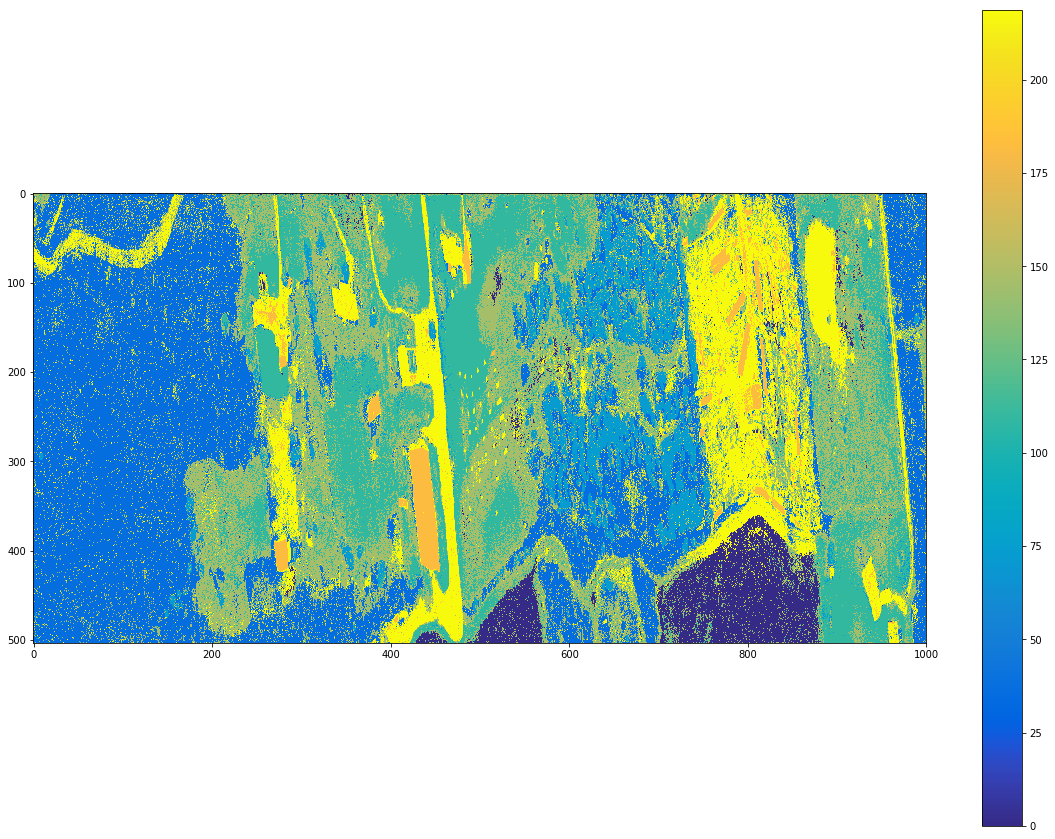

In [23]:
nl, ns, nb = sz
fig, axs = plt.subplots(nrows=1, ncols=1);
cmap = plt.get_cmap('parula')

im = axs.imshow(np.rot90(final_class_ixs.reshape([nl, ns], order='F') * 255/num_classes), cmap=cmap);

fig.colorbar(im, ax=axs);

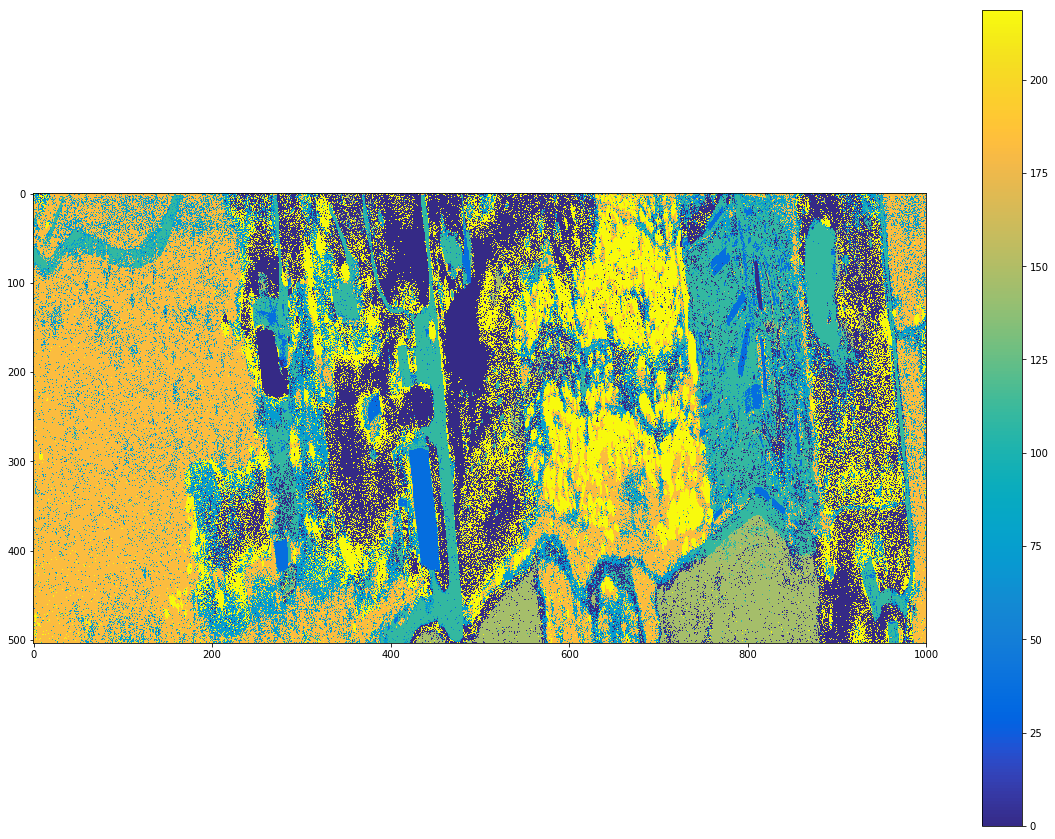

In [24]:
tmp = np.zeros([nl*ns])
tmp[valid_ixs] = final_class_ixs_masked
nl, ns, nb = sz
fig, axs = plt.subplots(nrows=1, ncols=1);
cmap = plt.get_cmap('parula')

#im = axs.imshow(np.rot90(final_class_ixs_masked.reshape([nl, ns], order='F') * 255/num_classes), cmap=cmap);
im = axs.imshow(np.rot90(tmp.reshape([nl, ns], order='F') * 255/num_classes), cmap=cmap);

fig.colorbar(im, ax=axs);

In [25]:
from sklearn.cluster import KMeans

In [32]:
%%timeit
km = KMeans(n_clusters=num_classes, random_state=12345).fit(hsi_data_mat.transpose())

58.8 s ± 524 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
km_masked = KMeans(n_clusters=num_classes, random_state=12345).fit(hsi_data_mat_masked.transpose())

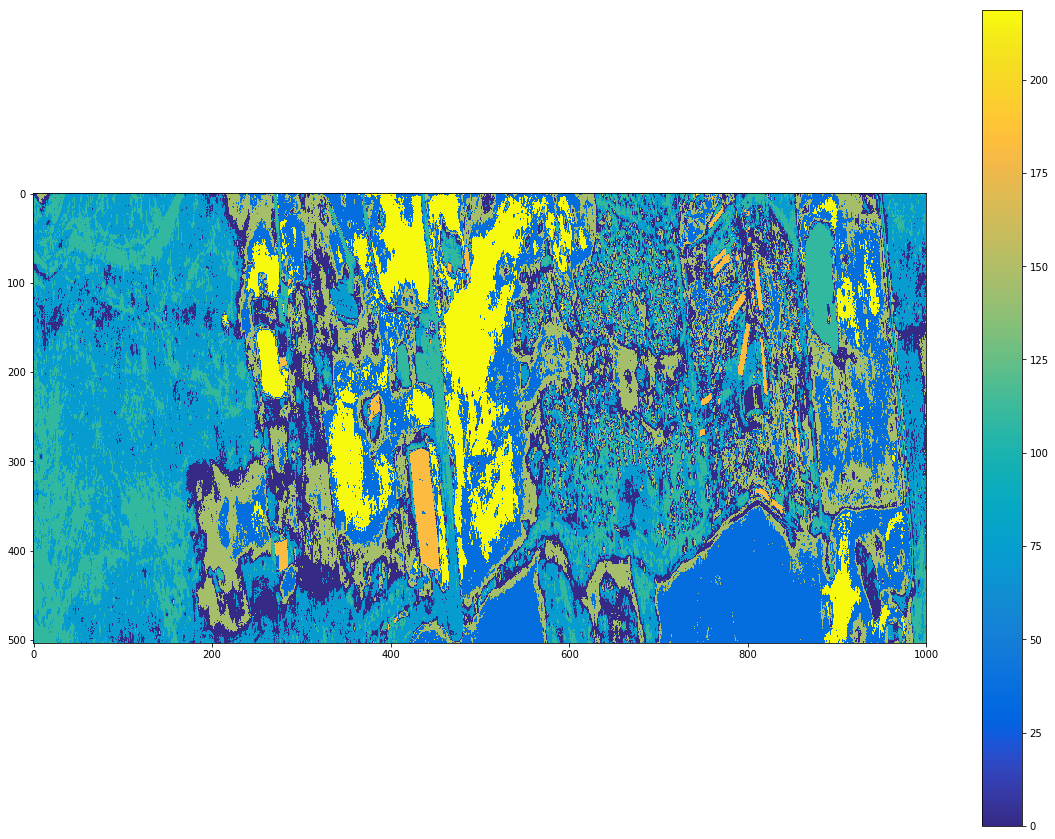

In [28]:
nl, ns, nb = sz
fig, axs = plt.subplots(nrows=1, ncols=1);
cmap = plt.get_cmap('parula')

im = axs.imshow(np.rot90(km.labels_.reshape([nl, ns], order='F') * 255/num_classes), cmap=cmap);

fig.colorbar(im, ax=axs);

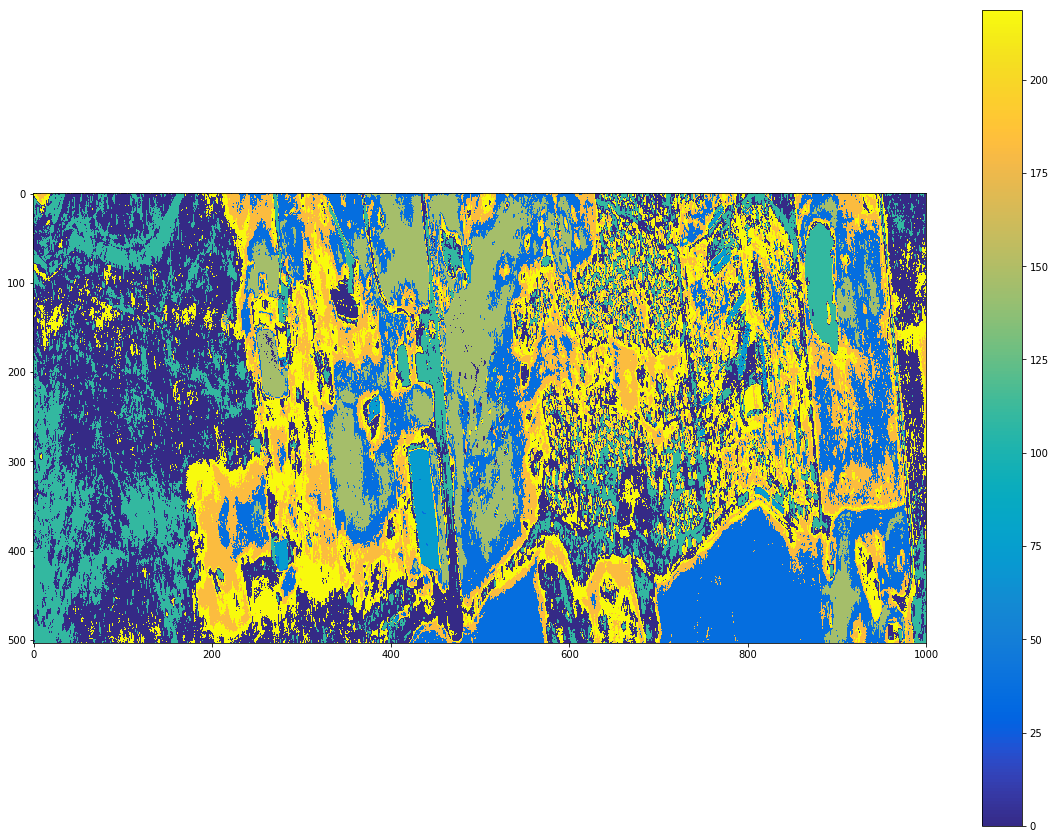

In [29]:
tmp = np.zeros([nl*ns])
tmp[valid_ixs] = km_masked.labels_
#background_ix

nl, ns, nb = sz
fig, axs = plt.subplots(nrows=1, ncols=1);
cmap = plt.get_cmap('parula')

#im = axs.imshow(np.rot90(km_masked.labels_.reshape([nl, ns], order='F') * 255/num_classes), cmap=cmap);
im = axs.imshow(np.rot90(tmp.reshape([nl, ns], order='F') * 255/num_classes), cmap=cmap);

fig.colorbar(im, ax=axs);

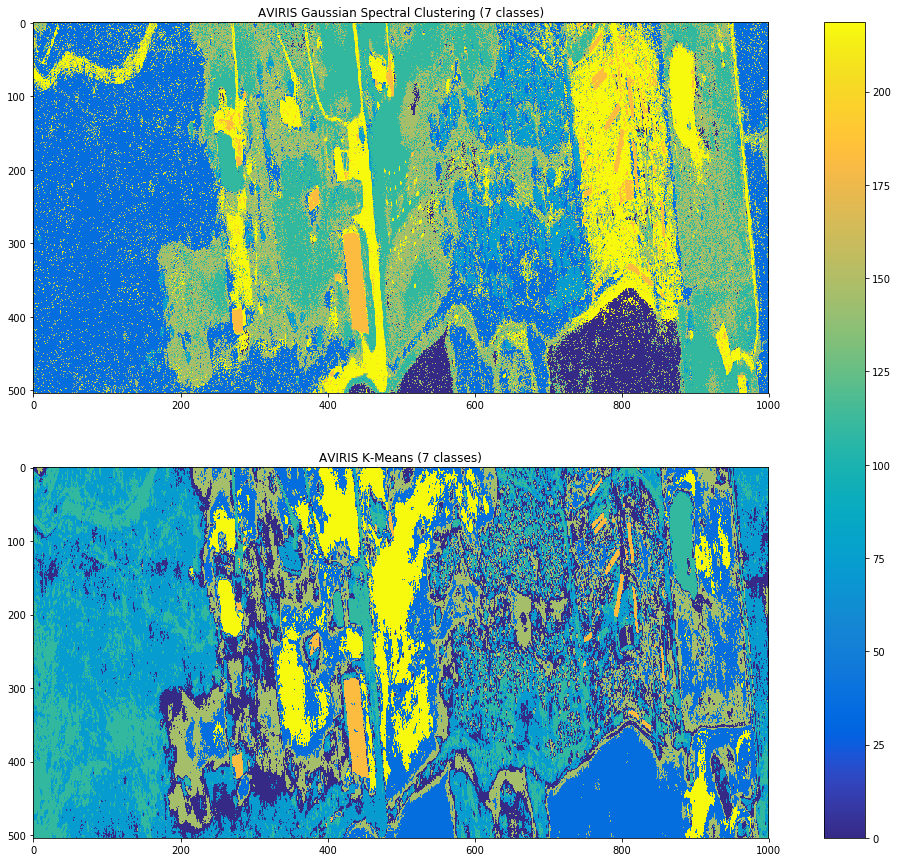

In [30]:
# Side by side comparison
fig, axs = plt.subplots(nrows=2, ncols=1);
cmap = plt.get_cmap('parula')

gsc_im = axs[0].imshow(np.rot90(final_class_ixs.reshape([nl, ns], order='F') * 255/num_classes), cmap=cmap);
km_im = axs[1].imshow(np.rot90(km.labels_.reshape([nl, ns], order='F') * 255/num_classes), cmap=cmap);

axs[0].set_title('AVIRIS Gaussian Spectral Clustering ({} classes)'.format(num_classes))
axs[1].set_title('AVIRIS K-Means ({} classes)'.format(num_classes))
#fig.subplots_adjust(right=0.8)
#cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(gsc_im, ax=axs);